In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = int(np.sqrt(input_dim))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
class Autoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z = fc(f3, self.n_z, scope='enc_fc4', activation_fn=tf.nn.relu)

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.recon_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss
        }
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [3]:
def trainer(model_object, learning_rate=1e-4, 
            batch_size=64, num_epoch=100, n_z=16, log_step=5):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and backward pass 
            # Report computed losses
            losses = model.run_single_step(batch[0])
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [6]:
# Train a model
model = trainer(Autoencoder)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[Epoch 0] recon_loss: 164.988  (3.746 sec/epoch)
[Epoch 5] recon_loss: 104.206  (3.534 sec/epoch)
[Epoch 10] recon_loss: 93.152  (3.437 sec/epoch)
[Epoch 15] recon_loss: 89.306  (3.556 sec/epoch)
[Epoch 20] recon_loss: 90.641  (3.498 sec/epoch)
[Epoch 25] recon_loss: 80.942  (3.774 sec/epoch)
[Epoch 30] recon_loss: 85.836  (3.675 sec/epoch)
[Epoch 35] recon_loss: 85.152  (3.465 sec/epoch)
[Epoch 40] recon_loss: 81.071  (3.566 sec/epoch)
[Epoch 45] recon_loss: 81.885  (3.523 sec/epoch)
[Epoch 50] recon_loss: 80.200  (3.466 sec/epoch)
[Epoch 55] recon_loss: 82.723  (3.463 sec/epoch)
[Epoch 60] recon_loss: 77.384  (3.431 sec/epoch)
[Epoch 65] recon_loss: 77.133  (3.464 sec/epoch)
[Epoch 70] recon_loss: 77.798  (3.480 sec/epoch)
[Epoch 75] recon_loss: 76.485  (3.441 sec/epoch)
[Epoch 80] recon_loss: 79.299  (3.489 sec/epoch)
[Epoch 85] recon_loss: 77.283  (3.460 sec/epoch

In [7]:
def test_reconstruction(model, mnist, h=28, w=28, batch_size=100):
    # Test the trained model: reconstruction
    batch = mnist.test.next_batch(batch_size)
    x_reconstructed = model.reconstructor(batch[0])

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[0][i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

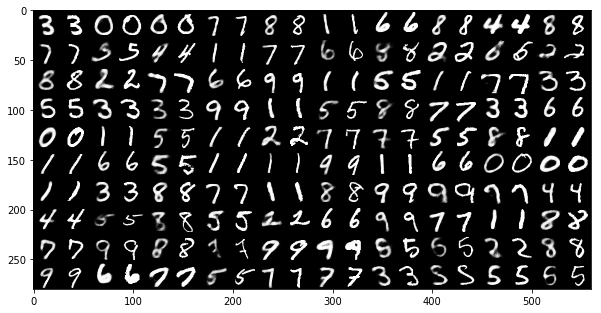

In [8]:
test_reconstruction(model, mnist)

In [9]:
# Train a model with 2d latent space
model_2d = trainer(Autoencoder, n_z=2)

C:\Users\Takato\Anaconda3\envs\cs599pro\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] recon_loss: 190.053  (4.233 sec/epoch)
[Epoch 5] recon_loss: 163.833  (3.367 sec/epoch)
[Epoch 10] recon_loss: 155.188  (3.393 sec/epoch)
[Epoch 15] recon_loss: 154.752  (3.384 sec/epoch)
[Epoch 20] recon_loss: 140.565  (3.365 sec/epoch)
[Epoch 25] recon_loss: 142.543  (3.397 sec/epoch)
[Epoch 30] recon_loss: 140.537  (3.398 sec/epoch)
[Epoch 35] recon_loss: 144.836  (3.378 sec/epoch)
[Epoch 40] recon_loss: 142.514  (3.943 sec/epoch)
[Epoch 45] recon_loss: 130.802  (3.928 sec/epoch)
[Epoch 50] recon_loss: 153.337  (3.858 sec/epoch)
[Epoch 55] recon_loss: 136.362  (3.412 sec/epoch)
[Epoch 60] recon_loss: 129.480  (3.400 sec/epoch)
[Epoch 65] recon_loss: 137.520  (3.392 sec/epoch)
[Epoch 70] recon_loss: 133.962  (3.664 sec/epoch)
[Epoch 75] recon_loss: 127.934  (3.656 sec/epoch)
[Epoch 80] recon_loss: 127.061  (3.447 sec/epoch)
[Epoch 85] recon_loss: 136.974  (3.420 sec/epoch)
[Epoch 90] recon_loss: 135.116  (3.408 sec/epoch)
[Epoch 95] recon_loss: 129.091  (3.464 sec/epoch)
Do

In [10]:
def test_transformation(model_2d, mnist, batch_size=3000):
    # Test the trained model: transformation
    assert model_2d.n_z == 2
    batch = mnist.test.next_batch(batch_size)
    z = model_2d.transformer(batch[0])
    plt.figure(figsize=(10, 8)) 
    plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1), s=20)
    plt.colorbar()
    plt.grid()

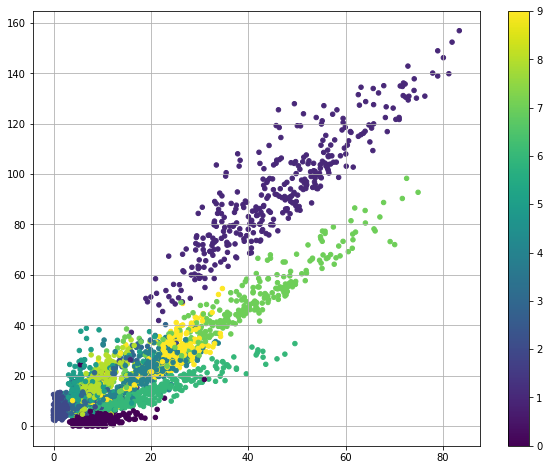

In [11]:
test_transformation(model_2d, mnist)

In [12]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [13]:
# Train a model
model_vae = trainer(VariantionalAutoencoder)

[Epoch 0] recon_loss: 197.982  latent_loss: 3.154  total_loss: 201.136  (4.571 sec/epoch)
[Epoch 5] recon_loss: 119.876  latent_loss: 13.292  total_loss: 133.167  (3.717 sec/epoch)
[Epoch 10] recon_loss: 107.854  latent_loss: 15.573  total_loss: 123.427  (3.666 sec/epoch)
[Epoch 15] recon_loss: 102.237  latent_loss: 17.289  total_loss: 119.526  (3.651 sec/epoch)
[Epoch 20] recon_loss: 99.235  latent_loss: 17.175  total_loss: 116.410  (3.678 sec/epoch)
[Epoch 25] recon_loss: 92.328  latent_loss: 18.584  total_loss: 110.912  (3.681 sec/epoch)
[Epoch 30] recon_loss: 95.562  latent_loss: 19.408  total_loss: 114.970  (3.679 sec/epoch)
[Epoch 35] recon_loss: 91.375  latent_loss: 19.074  total_loss: 110.449  (3.662 sec/epoch)
[Epoch 40] recon_loss: 92.371  latent_loss: 18.449  total_loss: 110.820  (3.669 sec/epoch)
[Epoch 45] recon_loss: 92.693  latent_loss: 18.720  total_loss: 111.413  (3.641 sec/epoch)
[Epoch 50] recon_loss: 89.988  latent_loss: 19.634  total_loss: 109.622  (3.672 sec/epoch

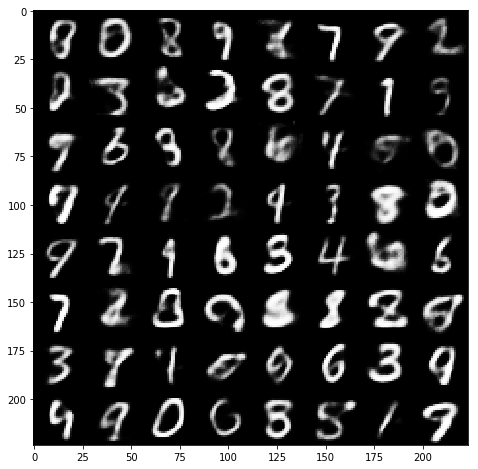

In [14]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model_vae.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

In [15]:
# Train a model with 2d latent space
model_2d_vae = trainer(VariantionalAutoencoder, n_z=2)

[Epoch 0] recon_loss: 190.780  latent_loss: 3.910  total_loss: 194.690  (4.002 sec/epoch)
[Epoch 5] recon_loss: 152.372  latent_loss: 4.900  total_loss: 157.272  (3.662 sec/epoch)
[Epoch 10] recon_loss: 150.097  latent_loss: 5.319  total_loss: 155.416  (3.732 sec/epoch)
[Epoch 15] recon_loss: 144.613  latent_loss: 5.662  total_loss: 150.275  (3.615 sec/epoch)
[Epoch 20] recon_loss: 139.384  latent_loss: 5.561  total_loss: 144.945  (3.623 sec/epoch)
[Epoch 25] recon_loss: 148.427  latent_loss: 5.687  total_loss: 154.115  (3.608 sec/epoch)
[Epoch 30] recon_loss: 145.489  latent_loss: 5.963  total_loss: 151.452  (3.617 sec/epoch)
[Epoch 35] recon_loss: 137.692  latent_loss: 5.699  total_loss: 143.391  (3.753 sec/epoch)
[Epoch 40] recon_loss: 142.169  latent_loss: 5.940  total_loss: 148.109  (3.689 sec/epoch)
[Epoch 45] recon_loss: 141.450  latent_loss: 6.264  total_loss: 147.714  (3.647 sec/epoch)
[Epoch 50] recon_loss: 138.010  latent_loss: 6.270  total_loss: 144.280  (3.591 sec/epoch)
[

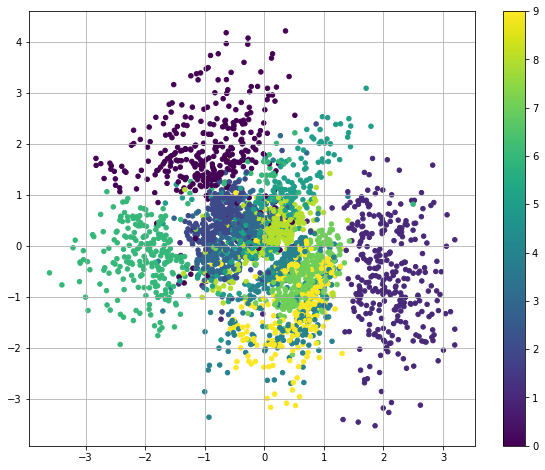

In [16]:
test_transformation(model_2d_vae, mnist)

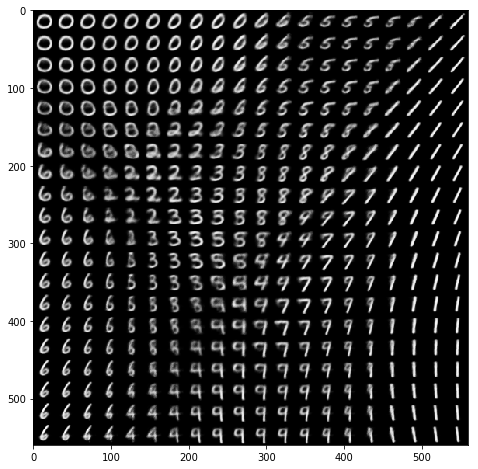

In [17]:
# Test the trained model: uniformly samlpe in the latent space
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d_vae.batch_size)
        x_hat = model_2d_vae.generator(z)
        I_latent[(n-i-1)*h:(n-i)*h, j*w:(j+1)*w] = x_hat[0].reshape(h, w)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")